# Thermal transport from HNEMD simulations
## Introduction
In this tutorial, we use the HNEMD method to study heat transport in graphene at 300 K and zero pressure. Here we consider the diffusive regime. The ballistic regime can be found in the NEMD example. The spectral decomposition method as described in [[Fan 2019]](https://doi.org/10.1103/PhysRevB.99.064308) is used here.

### Importing Relevant Functions
The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [thermo](https://github.com/AlexGabourie/thermo) package.

In [4]:
from pylab import *
from ase.build import graphene_nanoribbon
from thermo.gpumd.preproc import add_group_by_position
from ase.io import write
from thermo.gpumd.data import load_kappa, load_shc
from thermo.gpumd.calc import running_ave, hnemd_spectral_kappa

### Preparing the Inputs
We consider a graphene sheet of size of about 25 nm x 25 nm (24000 atoms). The transport is in the $y$ direction. We divide the length in the $y$ direction into 2 groups, with 4000 atoms in group 0 and 20000 atoms in group 1
We use a Tersoff potential [[Tersoff 1989]](https://doi.org/10.1103/PhysRevB.39.5566) parameterized by Lindsay *et al.* [[Lindsay 2010]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.205441).

### Generate the ``model.xyz`` file

In [5]:
gnr = graphene_nanoribbon(100, 60, type='armchair', sheet=True, vacuum=3.35/2)
gnr.euler_rotate(theta=90)
l = gnr.cell.lengths()
gnr.cell = gnr.cell.new((l[0], l[2], l[1]))
l = l[2]
gnr.center()
gnr.pbc = [True, True, False]
gnr

Atoms(symbols='C24000', pbc=[True, True, False], cell=[245.95121467478057, 255.6, 3.35])

### Add Groups

In [6]:
Ly = 3*1.42*10
split = [0, Ly, 255.6]
ncounts = add_group_by_position(split, gnr, direction='y')
print("Atoms per group:", ncounts)
print("Total atoms:", sum(ncounts))

Atoms per group: [4000, 20000]
Total atoms: 24000


In [7]:
write("model.xyz", gnr, write_info = False) 

with open("model.xyz", "r") as fin:
    lines = fin.readlines() 
lines[1] = lines[1].split("R:3")[0] + "R:3:group:I:1" + lines[1].split("R:3")[1]
for i in range(len(lines) - 2):
    group_id = gnr.info[i]["groups"][0]
    lines[i + 2] = lines[i + 2][:-2] + f"\t{group_id}\n"
    
with open("model.xyz", "w") as fout:
    fout.writelines(lines)

### The ``run.in`` file
The ``run.in`` input file is given below:<br>
```
potential    ../../../../potentials/tersoff/Graphene_Lindsay_2010_modified.txt
velocity     300

ensemble     nvt_nhc 300 300 100
time_step    1 
dump_thermo  1000        
run          1000000

ensemble      nvt_nhc 300 300 100
compute_hnemd 1000 0 0.00001 0
compute_shc   2 250 1 1000 400.0 group 0 0
run           10000000
```
- The first line uses the ``potential`` keyword to define the potential to be used, which is specified in the file [Graphene_Lindsay_2010_modified.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Graphene_Lindsay_2010_modified.txt).

- The second line uses the ``velocity`` keyword and sets the velocities to be initialized with a temperature of 300 K.  

- There are two runs. The first ``run`` serves as the equilibration stage.
  - Here, the NVT ``ensemble`` (the Nose-Hoover chain thermostat) is used. The target temperature is 300 K and the thermostat coupling constant is 0.1 ps (100 time steps). 
  - The ``time_step`` for integration is 1 fs. 
  - The thermodynamic quantities will be output every 1000 steps. 
  - There are $10^6$ steps (1 ns) for this run. 
- The second ``run`` is for production. 
  - Here, the global temperature is controlled by the Nose-Hoover chain thermostat (``ensemble``) with the same parameters as in the equilibration stage.
  - The ``compute_hnemd`` keyword is used to add a driving force and compute the thermal conductivity using the HNEMD method [[Fan 2019]](https://doi.org/10.1103/PhysRevB.99.064308). Here, the conductivity data will be averaged for each 1000 steps before written out, and the driving force parameter is $10^{-5}$ A<sup>-1</sup> and is in the $y$ direction. 
  - The line with the ``compute_shc`` keyword is used to compute the spectral heat current (SHC). The SHC will be calculated for group ``0`` in grouping method ``0``. The relevant data will be sampled every 2 steps and the maximum correlation time is $250 \times 2 \times 1~{\rm fs} = 500~{\rm fs}$. The transport directions is ``1`` ($y$ direction). The number of frequency points is 1000 and the maximum angular frequncy is 400 THz.
  - There are $10^7$ steps (10 ns) in the production ``run``. This is just an example. To get more accurate results, we suggest you use $2 \times 10^7$ steps (20 ns) and do a few independent runs and then average the relevant data.

## Results and Discussion
### Computation Time
Using a GeForce RTX 2080 Ti GPU, the HNEMD simulation takes about 1.5 hours.

### Figure Properties

In [8]:
aw = 2
fs = 16
font = {'size'   : fs}
matplotlib.rc('font', **font)
matplotlib.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

### Plot HNEMD Results
The ``kappa.out`` output file is loaded and processed to create the following figure.

In [9]:
kappa = load_kappa()
kappa.keys()

dict_keys(['kxi', 'kxo', 'kyi', 'kyo', 'kz'])

In [10]:
t = np.arange(1,kappa['kxi'].shape[0]+1)*0.001  # ns
kappa['kyi_ra'] = running_ave(kappa['kyi'],t)
kappa['kyo_ra'] = running_ave(kappa['kyo'],t)
kappa['kxi_ra'] = running_ave(kappa['kxi'],t)
kappa['kxo_ra'] = running_ave(kappa['kxo'],t)
kappa['kz_ra'] = running_ave(kappa['kz'],t)

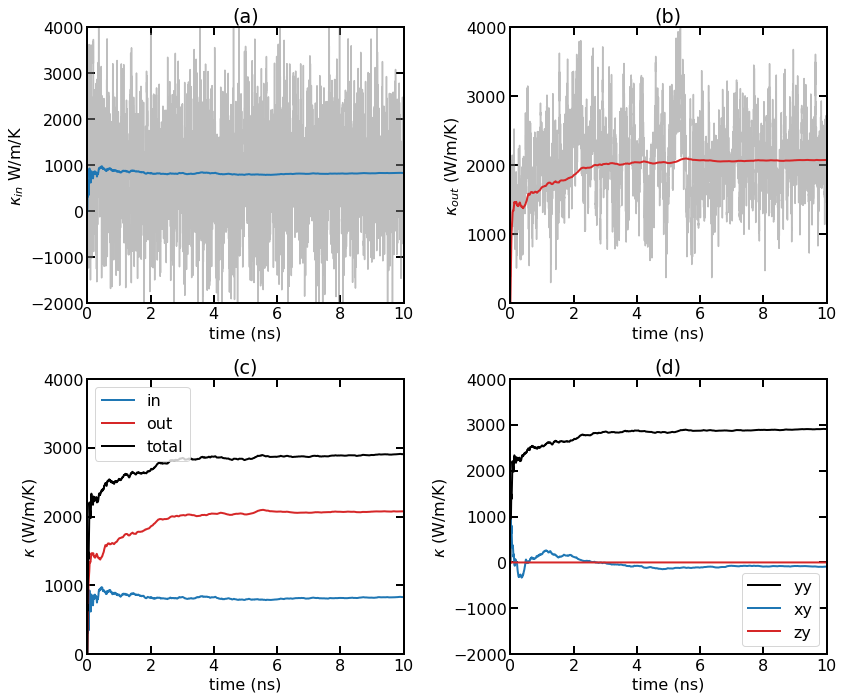

In [11]:
figure(figsize=(12,10))
subplot(2,2,1)
set_fig_properties([gca()])
plot(t, kappa['kyi'],color='C7',alpha=0.5)
plot(t, kappa['kyi_ra'], linewidth=2)
xlim([0, 10])
gca().set_xticks(range(0,11,2))
ylim([-2000, 4000])
gca().set_yticks(range(-2000,4001,1000))
xlabel('time (ns)')
ylabel(r'$\kappa_{in}$ W/m/K')
title('(a)')

subplot(2,2,2)
set_fig_properties([gca()])
plot(t, kappa['kyo'],color='C7',alpha=0.5)
plot(t, kappa['kyo_ra'], linewidth=2, color='C3')
xlim([0, 10])
gca().set_xticks(range(0,11,2))
ylim([0, 4000])
gca().set_yticks(range(0,4001,1000))
xlabel('time (ns)')
ylabel(r'$\kappa_{out}$ (W/m/K)')
title('(b)')

subplot(2,2,3)
set_fig_properties([gca()])
plot(t, kappa['kyi_ra'], linewidth=2)
plot(t, kappa['kyo_ra'], linewidth=2, color='C3')
plot(t, kappa['kyi_ra']+kappa['kyo_ra'], linewidth=2, color='k')
xlim([0, 10])
gca().set_xticks(range(0,11,2))
ylim([0, 4000])
gca().set_yticks(range(0,4001,1000))
xlabel('time (ns)')
ylabel(r'$\kappa$ (W/m/K)')
legend(['in', 'out', 'total'])
title('(c)')


subplot(2,2,4)
set_fig_properties([gca()])
plot(t, kappa['kyi_ra']+kappa['kyo_ra'],color='k', linewidth=2)
plot(t, kappa['kxi_ra']+kappa['kxo_ra'], color='C0', linewidth=2)
plot(t, kappa['kz_ra'], color='C3', linewidth=2)
xlim([0, 10])
gca().set_xticks(range(0,11,2))
ylim([0, 4000])
gca().set_yticks(range(-2000,4001,1000))
xlabel('time (ns)')
ylabel(r'$\kappa$ (W/m/K)')
legend(['yy', 'xy', 'zy'])
title('(d)')

tight_layout()
show()

**(a)** In-plane thermal conductivity $\kappa_{\rm in}(t)$ as a function of production time. **(b)** Out-of-plane thermal conductivity $\kappa_{\rm out}(t)$ as a function of production time. **(c)** In-plane, out-of-plane, and total thermal conductivity as a function of production time. **(d)** Comparing $\kappa_{yy}$, $\kappa_{xy}$, and $\kappa_{zy}$.

- (a) The gray line represents the instant in-plane thermal conductivity $\kappa_{\rm in}(t)$ from the ``kappa.out`` file. The dashed line represents the cumulative time average:
$$
\kappa^{\rm ave}_{\rm in}(t) = \frac{1}{t} \int_0^t \kappa_{\rm in}(t') dt'
$$

* (b) Similar to (a), but for the out-of-plane thermal conductivity $\kappa_{\rm out}(t)$ and $\kappa^{\rm ave}_{\rm out}(t)$.

* (c) Cumulative time averaged in-plane, out-of-plane, and total thermal conductivity: $\kappa^{\rm ave}_{\rm in}(t)$, $\kappa^{\rm ave}_{\rm out}(t)$ and $\kappa^{\rm ave}_{\rm total}(t) = \kappa^{\rm ave}_{\rm in}(t) + \kappa^{\rm ave}_{\rm out}(t)$. It is clear that the out-of-plane phonons have a much large average phonon relaxation time (scattering time) than the in-plane phonons, and the thermal conductivity in pristine graphene is dominated by out-of-plane (flexural) phonons. This is consistent with the results from the EMD simulation as discussed in the EMD tutorial.

* (d) Some cumulative time averaged thermal conductivity components of the tensor: $\kappa^{\rm ave}_{yy}(t)$, $\kappa^{\rm ave}_{xy}(t)$ and $\kappa^{\rm ave}_{zy}(t)$. It is clear that the off-diagonal components of the thermal conductivity tensor are zero.

### Plot Spectral Heat Current Results
The ``shc.out`` output file is loaded and processed to create the following figure.

In [12]:
shc = load_shc(Nc=250, num_omega=1000)['run0']
shc.keys()

dict_keys(['t', 'Ki', 'Ko', 'nu', 'jwi', 'jwo'])

In [13]:
l = gnr.cell.lengths()
Lx, Lz = l[0], l[2]
V = Lx * Ly * Lz
T = 300
Fe = 1.0e-5
hnemd_spectral_kappa(shc, Fe, T, V)
shc['kw'] = shc['kwi'] + shc['kwo']
shc['K'] = shc['Ki'] + shc['Ko']
Gc = np.load('Gc.npy')
shc.keys()

dict_keys(['t', 'Ki', 'Ko', 'nu', 'jwi', 'jwo', 'kwi', 'kwo', 'kw', 'K'])

In [14]:
lambda_i = shc['kw']/Gc
length = logspace(1,6,100)
k_L = np.zeros_like(length)
for i, el in enumerate(length):
    k_L[i] = np.trapz(shc['kw']/(1+lambda_i/el), shc['nu'])

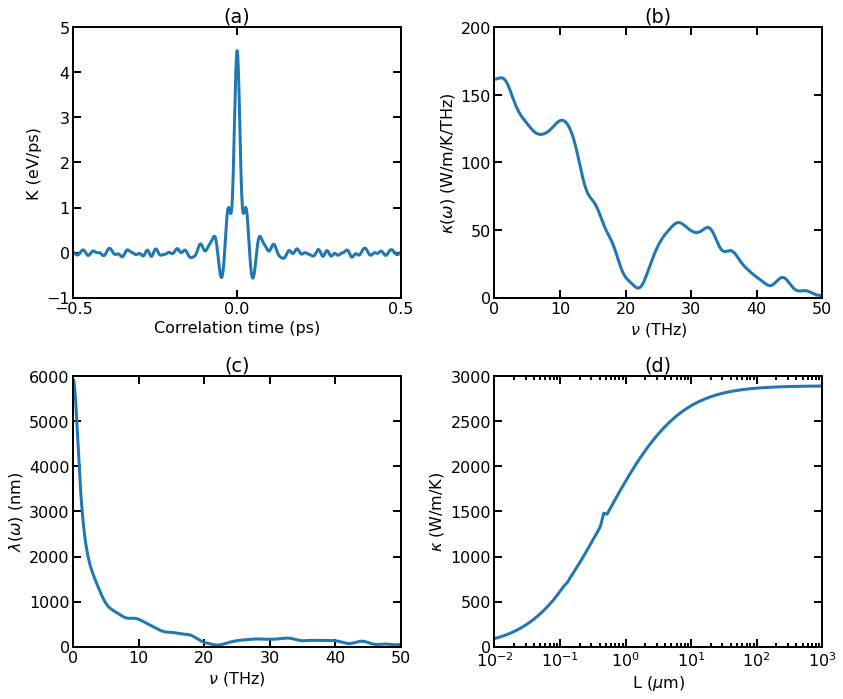

In [15]:
figure(figsize=(12,10))
subplot(2,2,1)
set_fig_properties([gca()])
plot(shc['t'], shc['K']/Ly, linewidth=3)
xlim([-0.5, 0.5])
gca().set_xticks([-0.5, 0, 0.5])
ylim([-1, 5])
gca().set_yticks(range(-1,6,1))
ylabel('K (eV/ps)')
xlabel('Correlation time (ps)')
title('(a)')

subplot(2,2,2)
set_fig_properties([gca()])
plot(shc['nu'], shc['kw'],linewidth=3)
xlim([0, 50])
gca().set_xticks(range(0,51,10))
ylim([0, 200])
gca().set_yticks(range(0,201,50))
ylabel(r'$\kappa$($\omega$) (W/m/K/THz)')
xlabel(r'$\nu$ (THz)')
title('(b)')

subplot(2,2,3)
set_fig_properties([gca()])
plot(shc['nu'], lambda_i,linewidth=3)
xlim([0, 50])
gca().set_xticks(range(0,51,10))
ylim([0, 6000])
gca().set_yticks(range(0,6001,1000))
ylabel(r'$\lambda$($\omega$) (nm)')
xlabel(r'$\nu$ (THz)')
title('(c)')

subplot(2,2,4)
set_fig_properties([gca()])
semilogx(length/1000, k_L,linewidth=3)
xlim([1e-2, 1e3])
ylim([0, 3000])
gca().set_yticks(range(0,3001,500))
ylabel(r'$\kappa$ (W/m/K)')
xlabel(r'L ($\mu$m)')
title('(d)')

tight_layout()
show()

**(a)** Virial-velocity correlation function $K(t)$. **(b)** Spectral thermal conductivity $\kappa(\omega)$. **(c)** Spectral phonon mean free path $\lambda(\omega)$. **(d)** Length-dependent thermal conductivity $\kappa(L)$.

- The above figure shows the results from the HNEMD simulation [[Fan 2019]](https://doi.org/10.1103/PhysRevB.99.064308). 
  - (a) The virial-velocity correlation function $K(t)$. See the [theoretical background section](https://gpumd.org/theory) for the definition of this quantity.
  - (b) The spectral thermal conductivity $\kappa(\omega)$. See the [theoretical background section](https://gpumd.org/theory) for the definition of this quantity.
  - (c) The spectral phonon mean free path calculated as [[Fan 2019]](https://doi.org/10.1103/PhysRevB.99.064308) 
$$
\lambda(\omega)=\kappa(\omega)/G(\omega),
$$
where $G(\omega)$ is the quasi-ballistic spectral thermal conductance from the above NEMD simulation.
  - (d) The length-dependent thermal conductivity calculated as [[Fan 2019]](https://doi.org/10.1103/PhysRevB.99.064308)
$$
\kappa(L) = \int \frac{d\omega}{2\pi} \frac{\kappa(\omega)}{1 + \lambda(\omega)/L}.
$$

## References
- [Fan 2019] Zheyong Fan, Haikuan Dong, Ari Harju, and Tapio Ala-Nissila, [Homogeneous nonequilibrium molecular dynamics method for heat transport and spectral decomposition with many-body potentials](https://doi.org/10.1103/PhysRevB.99.064308), Phys. Rev. B **99**, 064308 (2019).
- [Lindsay 2010] L. Lindsay and D.A. Broido, [Optimized Tersoff and Brenner emperical potential parameters for lattice dynamics and phonon thermal transport in carbon nanotubes and graphene](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B, **81**, 205441 (2010).
- [Tersoff 1989] J. Tersoff, [Modeling solid-state chemistry: Interatomic potentials for multicomponent systems](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B 39, 5566(R) (1989).